# 决策树

## 决策树

### 决策树分类原理

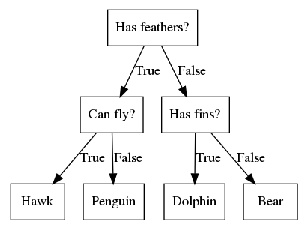

In [6]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

mglearn.plots.plot_animal_tree()

### 决策树分类

决策树减小模型复杂度的方法为剪枝方法，主要为**预剪枝**与**后剪枝**  
**预剪枝**训练时剪枝
**后剪枝**训练后剪枝  
方法有：限制树深度、叶子节点数量、节点中信息亮很少的点

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

canser = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(canser.data, canser.target,
                                                    stratify=canser.target, random_state=42)

# 不使用预剪枝，模型容易过拟合
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

print('decision tree:')
print('accuracy on training set:', tree.score(X_train, y_train))
print('accuracy on test set:', tree.score(X_test, y_test))
print('=' * 40)

# 预剪枝，限制最大深度为4
tree1 = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train)
print('decision tree with max depth 4:')
print('accuracy on training set:', tree1.score(X_train, y_train))
print('accuracy on test set:', tree1.score(X_test, y_test))
print('=' * 40)

decision tree:
accuracy on training set: 1.0
accuracy on test set: 0.9370629370629371
decision tree with max depth 4:
accuracy on training set: 0.9882629107981221
accuracy on test set: 0.951048951048951


### 决策树可视化分析

#### 查看决策过程

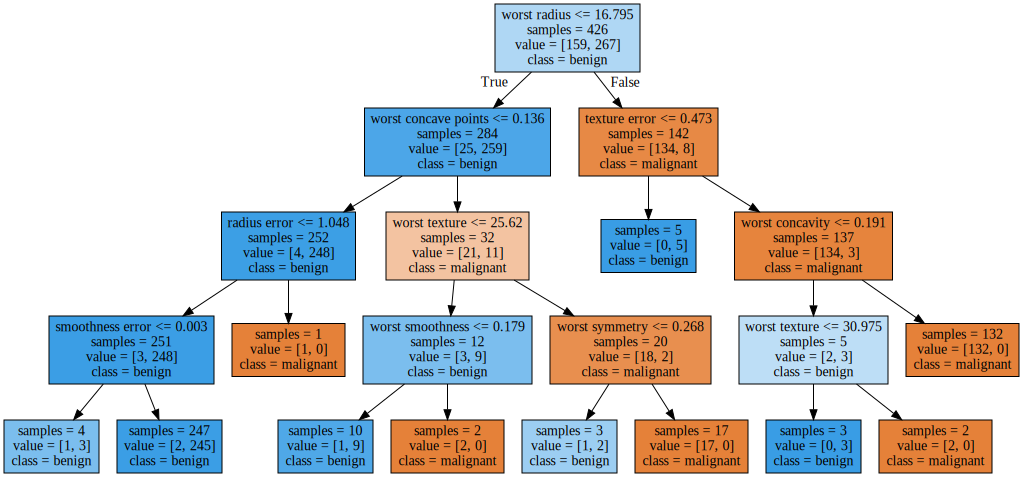

In [9]:
from sklearn.tree import export_graphviz
export_graphviz(tree1, out_file='tree.dot', class_names=['malignant', 'benign'],
               feature_names=canser.feature_names, impurity=False, filled=True)

import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### 可视化特征重要性

Feature importance :
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


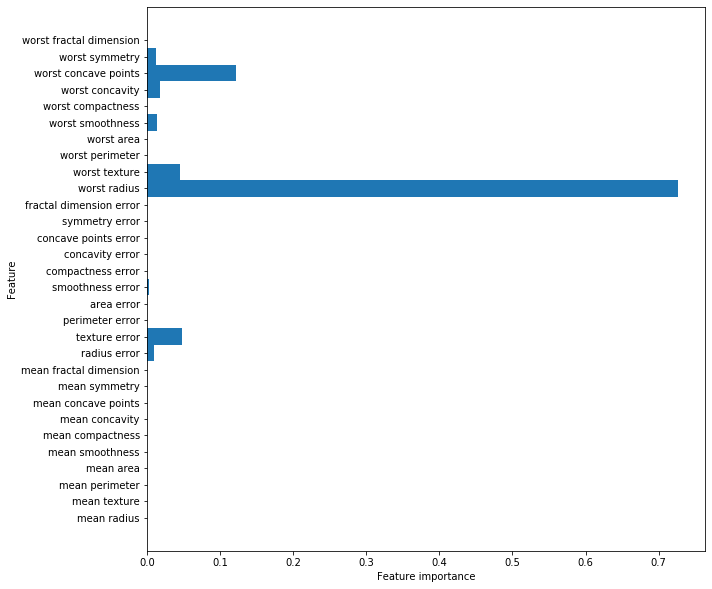

In [10]:
print('Feature importance :\n', tree1.feature_importances_)

def plot_importances_canser(model):
    n_features = canser.data.shape[1]
    plt.figure(figsize=(10, 10))
    plt.barh(range(n_features), model.feature_importances_, align='center', height=1 )
    plt.yticks(range(n_features), canser.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

plot_importances_canser(tree1)

### 决策树处理回归问题时，不能外推

#### 加载内存价格数据集

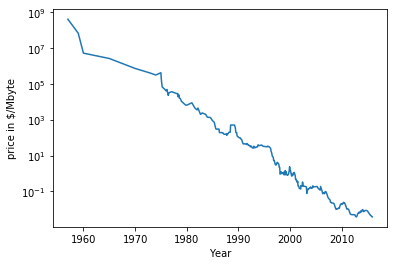

In [12]:
import pandas as pd

ram_prices = pd.read_csv('../data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)

plt.xlabel('Year')
plt.ylabel('price in $/Mbyte')
plt.show()

#### 使用决策树回归与线性回归预测

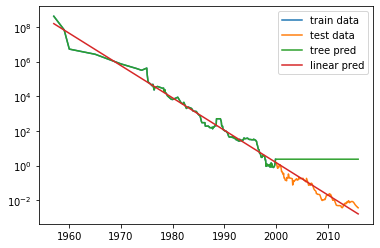

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date > 2000]

# 基于日期预测价格
X_train = data_train.date[:, np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 对所有数据进行预测
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

plt.semilogy(data_train.date, data_train.price, label='train data')
plt.semilogy(data_test.date, data_test.price, label='test data')
plt.semilogy(ram_prices.date, price_tree, label='tree pred')
plt.semilogy(ram_prices.date, price_lr, label='linear pred')

plt.legend()
plt.show()

## 决策树集成

### 随机森林

解决部分数据上的过拟合：构造多个不同决策树，结果取平均

构造决策树策略：
-  bootstrap 获取多个不同的训练样本
- 每个样本选取不同的训练特征

#### 随机森林解决分类

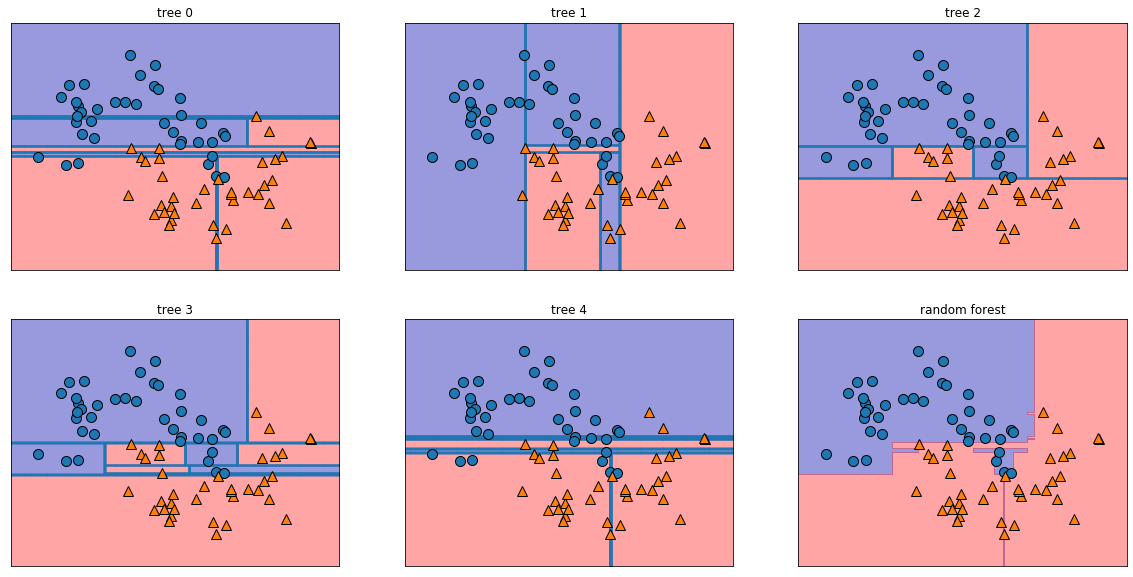

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# 构造包括5棵树的随机森林
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

fig, axes = plt.subplots(2,3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title('tree {}'.format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title('random forest')
mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train)
plt.show()

#### 随机森林应用于乳腺癌数据集

Accuracy of trainning set 1.0
Accuracy of test set 0.972027972027972


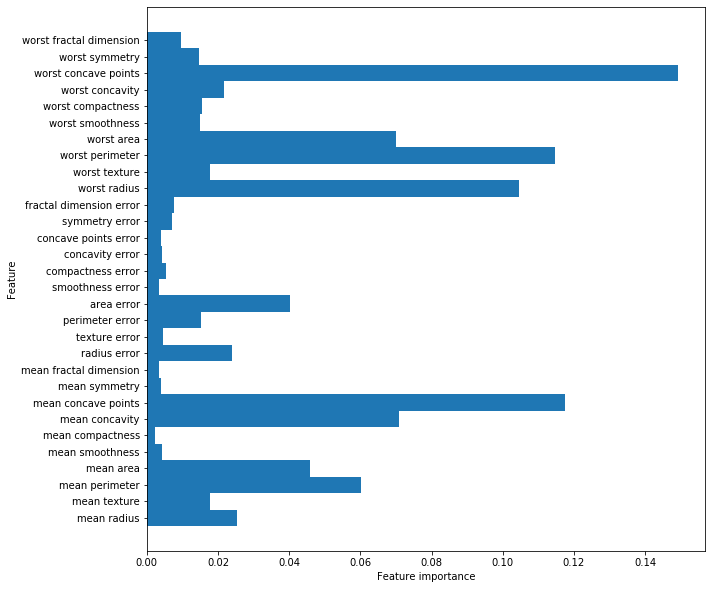

In [21]:
X_train, X_test, y_train, y_test = train_test_split(canser.data, canser.target, random_state=42)

forest = RandomForestClassifier(n_estimators=100, random_state=0)

forest.fit(X_train, y_train)

print('Accuracy of trainning set', forest.score(X_train, y_train))
print('Accuracy of test set', forest.score(X_test, y_test))

plot_importances_canser(forest)

### 梯度提升回归树

思路：连续构造树，后一颗以一定学习率纠正前一颗的错误

#### 预测乳腺癌数据

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(canser.data, canser.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
print('Accuracy of trainning set', gbrt.score(X_train, y_train))
print('Accuracy of test set', gbrt.score(X_test, y_test))

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1).fit(X_train, y_train)
print('Accuracy of trainning set', gbrt.score(X_train, y_train))
print('Accuracy of test set', gbrt.score(X_test, y_test))

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01).fit(X_train, y_train)
print('Accuracy of trainning set', gbrt.score(X_train, y_train))
print('Accuracy of test set', gbrt.score(X_test, y_test))

Accuracy of trainning set 1.0
Accuracy of test set 0.965034965034965
Accuracy of trainning set 0.9906103286384976
Accuracy of test set 0.972027972027972
Accuracy of trainning set 0.9882629107981221
Accuracy of test set 0.965034965034965
